In [1]:
import networkx as nx
import numpy as np
import pickle
from random import randint

%matplotlib inline
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
from tqdm.notebook import trange, tqdm
from time import time
from ipywidgets import interact, fixed
from scipy import optimize

import seaborn as sns
sns.set()

import os, sys
currentdir = os.path.dirname(os.path.realpath(__name__))
scriptsdir = os.path.dirname(currentdir)+'/scripts'
sys.path.append(scriptsdir)

from distances import dist_1d, dist_2d_lattice, dist_2d_spacial
from random_walks import simple_2d_random_walk, lazy_2d_random_walk
from generate_graph import Kleinberg_2d, small_world_2d, small_world_2d_new, sparse_lattice_graph
from analysis import get_path_forG, increase_walks_forG, get_new_start, get_mixing_time, get_prob_distribution, increase_prob_distribution, get_L1_norm_over_step_count, get_L1_norm

# Study of the total variance

In this section we analyze the total variance of the simulated probability to get to some nodes, using a lazy random walk, with the stationary probability of the small world graph.

\begin{equation}
d_i(t)=||P_i(x_t=y)-\pi(y)||_{TV}={1\over 2}||P_i(x_t=y)-\pi(y)||_1
\end{equation}
-$P_i(x_t=y)$ is the probability to get to some nodes y after t steps by starting at i node

-$\pi(y)$ is the stationary distribution, and therefore the stationary probability to get at y node

-$d_i(t)$ is the total variance after t steps starting at node i

The stationary distribution is
\begin{equation}
\pi(y)={\text{degree}(y)\over 2 *\text{number of nodes}}
\end{equation}

To simulate $P_i(x_t=y)$ we used this algorithm:

    1) choose a starting nodes i
    2) choose a fixed number of steps, called max_steps 
    3) choose a fixed number of different paths to perform a statistic, called max_walks
    4) perform an histogram for each steps containing the frequency of visits to each node for each path, and compute the L_1 norm with the stationary distribution

In this way we'll be able to compute the total variance after any choosen steps. The 3) step is the most important, since as we will see the total variance is bounded from below by this number 

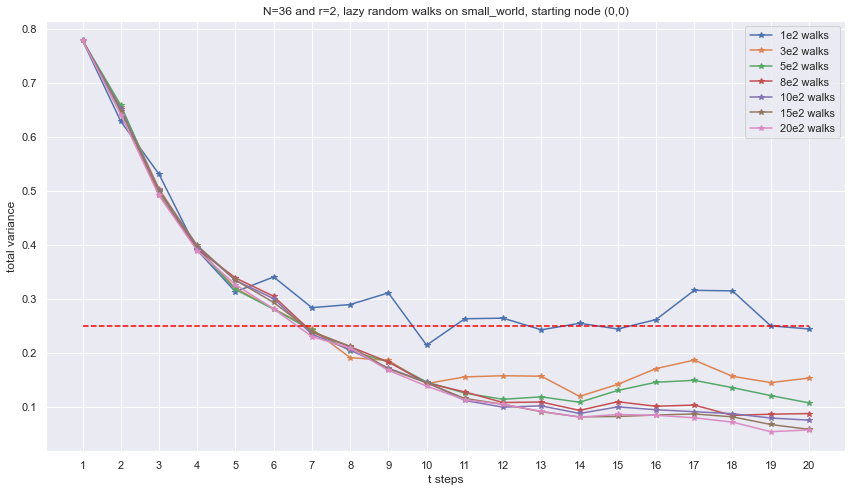

In [84]:
# Example code to construct the plot for a graph with 36 nodes


r=2
L=6
max_steps=40
max_walks=50*(L**2)
starting=(0,0)
#uploading the graph
pkl_file = open('Small_world_graphs/graph_L={}_r={}.pkl'.format(L,r), 'rb')
G = pickle.load(pkl_file)

#uploading the data
pkl_file = open('Small_world_L={}_r={}/L={}_small_world_steps({})_walks({})_starting={}.pkl'.format(L,r,L,max_steps,max_walks,starting), 'rb')
data = pickle.load(pkl_file)
norm_vector_list_parallel = []
for i in tqdm([1,3,5,8,10,15,20]):
    tic = time()
    norm_vector = get_L1_norm(G, L, data, max_steps=max_steps, max_walks=int(i*1e2))
    toc = time()
    time_i = toc-tic
    norm_vector_list_parallel.append((i, time_i, norm_vector))
# Plot
fig, ax1 = plt.subplots(figsize=(12,7))
#max_steps_plot=29
max_steps_plot=20
X=np.arange(1,max_steps_plot+1,1)
for i, time_i, norm_vector in norm_vector_list_parallel:
    ax1.plot(X,norm_vector[:max_steps_plot], "*-",label="{}e2 walks".format(i))
x=np.linspace(1,max_steps_plot,num=100)
y=np.linspace(0.25,0.25,num=100)
ax1.plot(x, y,'--', color='red')


ax1.set_title('N={} and r=2, lazy random walks on small_world, starting node (0,0)'.format(L**2))
ax1.set_xlabel('t steps')
ax1.set_ylabel('total variance')
X=np.arange(1,max_steps_plot+1,1)
ax1.set_xticks(X)
ax1.legend()
plt.tight_layout()
#plt.savefig(currentdir+'/Plots_new/'+'small_world_L={}_r={}_.png'.format(L,r), dpi=300)
plt.show()





for a small world graph with r=2


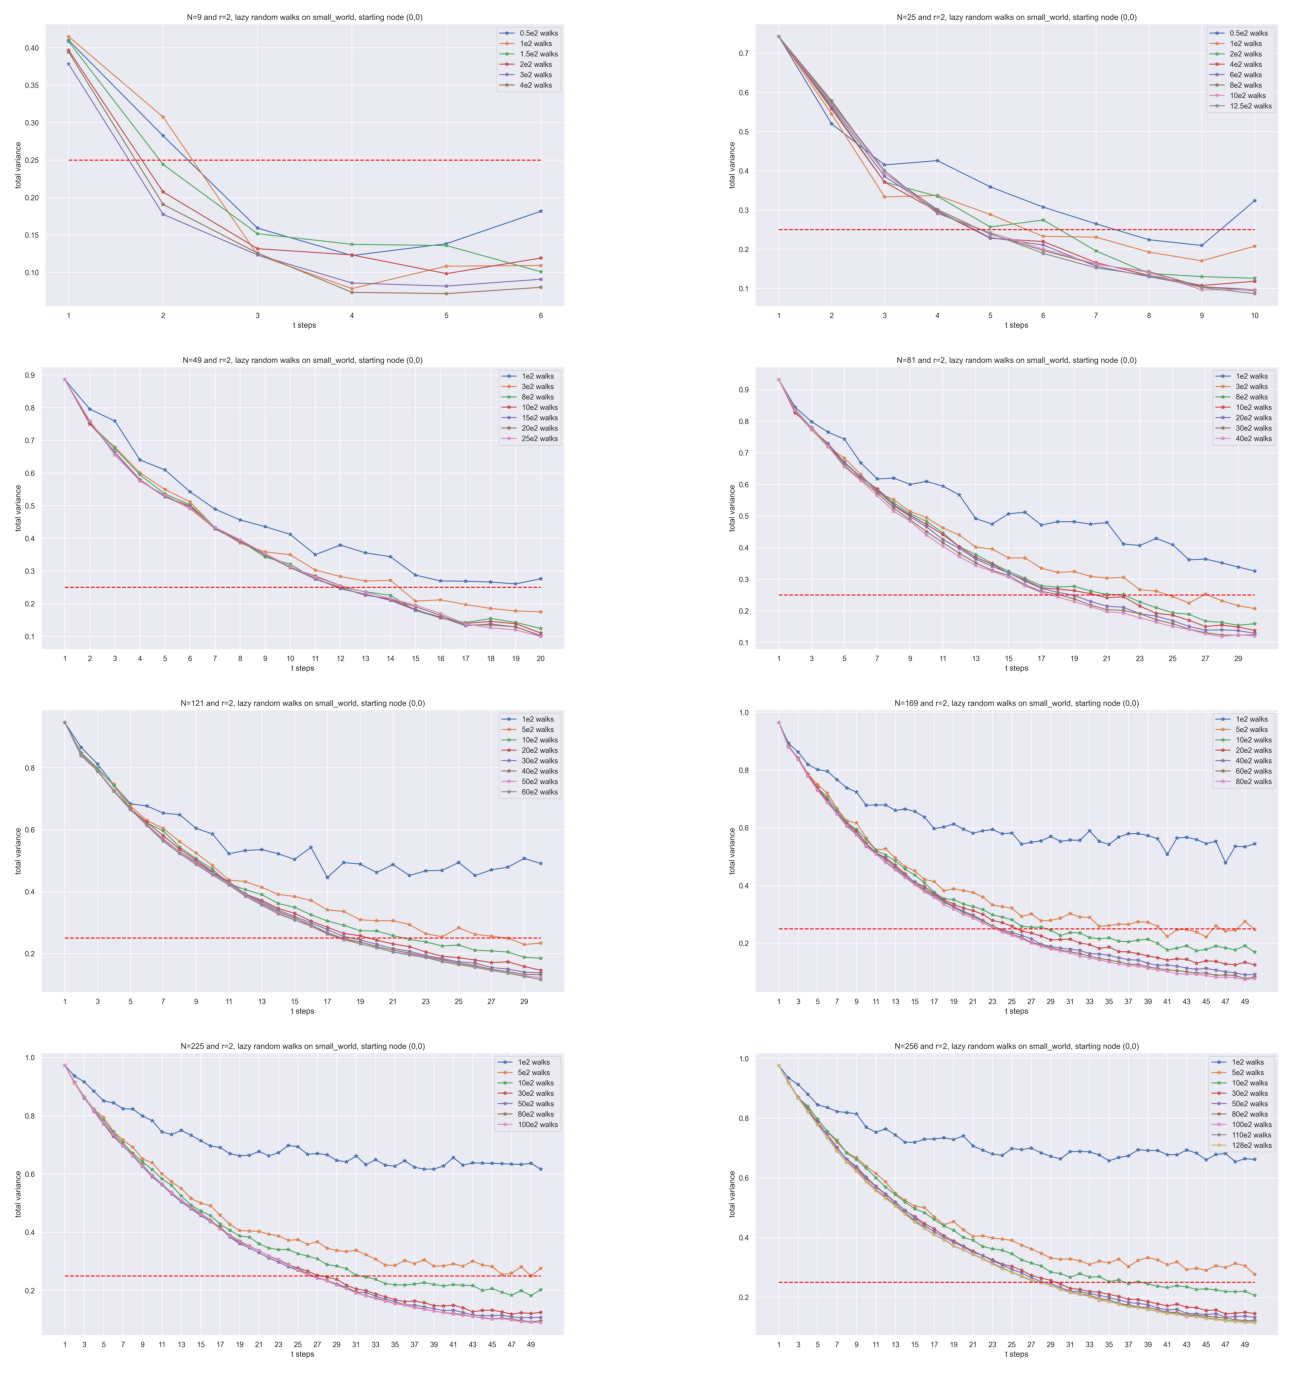

In [2]:
files=[]
for L in [3,5,7,9,11,13,15,16]:
    files.append("Plots_new/small_world_L={}_r=2_.png".format(L))

plt.figure(figsize=(20, 24))
print("for a small world graph with r=2")
for i, file_name in enumerate(files):
    plt.subplot(5, 2, i+1)
    plt.imshow(plt.imread(file_name))
    plt.axis('off')

plt.tight_layout()
plt.show()

From these plots we can see that the total variance is clearly bounded from below by the max_walks. Indeed the convergence with the stationary distribution in this approach is considered in the limit of max_walks tends to infinity (not in the steps tend to infinty as in the convergence theorem). 

Let's consider for example a huge number of walks for L=10 (100 number of nodes)

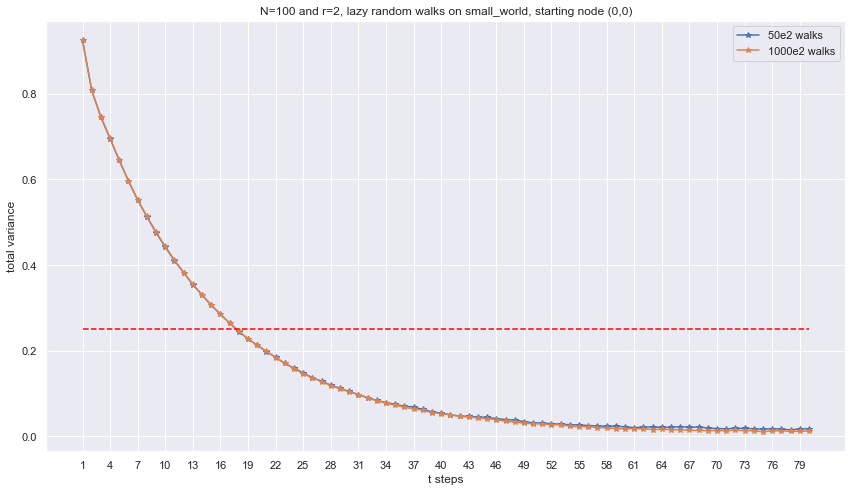

In [6]:
L=10
r=2
start=(0,0)
# load the graph
pkl_file = open('Small_world_graphs/graph_L={}_r={}.pkl'.format(L,r), 'rb')
G = pickle.load(pkl_file)
max_steps=80
max_walks=int(1e5)
paths=get_path_forG(G,L,max_steps=max_steps,max_walks=max_walks)
norm_vector_list_parallel = []
for i in [50,1000]:
    norm_vector = get_L1_norm(G, L, paths, max_steps=max_steps, max_walks=int(i*1e3))
    norm_vector_list_parallel.append((i,  norm_vector))
fig, ax1 = plt.subplots(figsize=(12,7))
#max_steps_plot=29
max_steps_plot=80
X=np.arange(1,max_steps_plot+1,1)
for i, norm_vector in norm_vector_list_parallel:
    ax1.plot(X,norm_vector[:max_steps_plot], "*-",label="{}e2 walks".format(i))
x=np.linspace(1,max_steps_plot,num=100)
y=np.linspace(0.25,0.25,num=100)
ax1.plot(x, y,'--', color='red')


ax1.set_title('N={} and r=2, lazy random walks on small_world, starting node (0,0)'.format(L**2))
ax1.set_xlabel('t steps')
ax1.set_ylabel('total variance')
X=np.arange(1,max_steps_plot+1,3)
ax1.set_xticks(X)
ax1.legend()
plt.tight_layout()
plt.savefig(currentdir+'/Plots_new/'+'small_world_L={}_r={}_HIGH_max_walks.png'.format(L,r), dpi=300)
plt.show()

We considered for our analysis of a graph with 100 nodes a max_walks=5000, here we can see that it is pretty similar to consider 100000 number of walks, so for computational convenience we can take max_walks=5000. In fact for our analysis we chose this rule 

\begin{equation}
\text{max walks}=50*(\text{number of nodes})
\end{equation}

# Study of the mixing time

The mixing time is the time (actually the number of steps in a Markov chain) needed to reach a reasonable proximity to the stationary distribution. It is computed as follow

\begin{equation}
T_{mix}=\max_i(\min_{t} d_i(t)<0.25)
\end{equation}

Namely the minimum steps needed to get close enough to the stationary distribution (0.25 of total variance) by starting at the worste node.

Since we are studying a non regular graph we have to compute the mixing time at each different starting node and then take the maximum. It is clear that the problem has an exponential complexity, but is a statistical approach possible for a greater number of nodes in a graph? 

In [23]:
# Creation of the plot

input_mix_time1 = open('vector_data/mix_time_for_each_start_L=16.pkl','rb')
input_mix_time2 = open('vector_data/mix_time_for_each_start_L=20.pkl','rb')
mixing_time1 = pickle.load(input_mix_time1)
mixing_time2 = pickle.load(input_mix_time2)
mixing_time = np.append(mixing_time1,mixing_time2,axis=0)
count=0
r=2
for L in range(2,21):
    mixing_time[count].sort()
    bins_list=[]
    for i in mixing_time[count]:
        if i not in bins_list:
            bins_list.append(i)
    bins_list.append(max(mixing_time[count])+1)
    bins_list=np.array(bins_list)-0.5
    '''
    fig, ax1 = plt.subplots(figsize=(12,7))
    ax1.hist(mixing_time[count], density=True, bins=bins_list)
    ax1.set_title('N={}, distribution of the possible mixing time'.format(L**2))
    ax1.set_xlabel('mixing time')
    ax1.set_ylabel('frequency')
    plt.savefig(currentdir+'/Plots_new/'+'histogram_mixing_time_L={}_r={}_.png'.format(L,r), dpi=300)
    plt.show()
    '''
    count=count+1

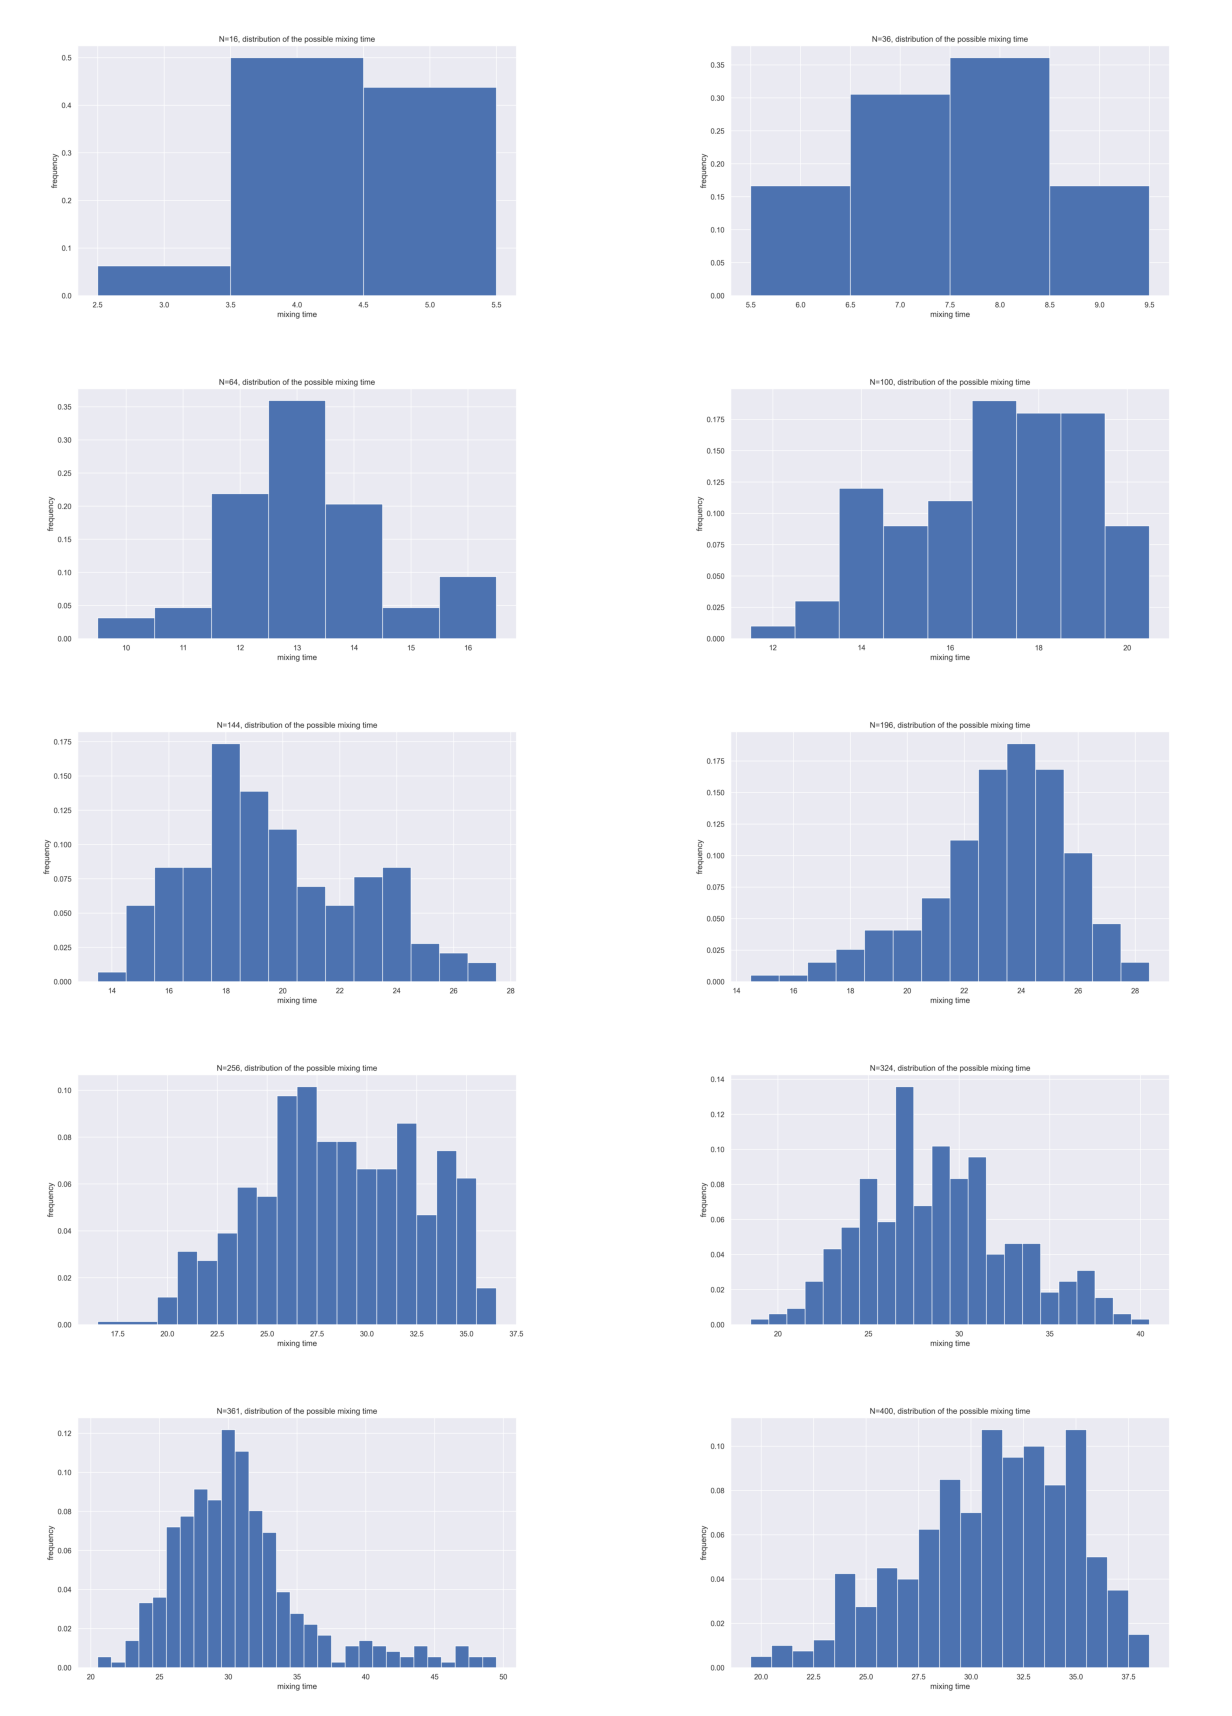

In [15]:
files=[]
for L in [4,6,8,10,12,14,16,18,19,20]:
    files.append("Plots_new/histogram_mixing_time_L={}_r=2_.png".format(L))

plt.figure(figsize=(20, 24))
for i, file_name in enumerate(files):
    plt.subplot(5, 2, i+1)
    plt.imshow(plt.imread(file_name))
    plt.axis('off')

plt.tight_layout()
plt.show()

The distribution of the possible mixing time that can be obtained does not have a defined structure when the number of nodes is increased, the variance increases but the mixing time cannot be deduced from the average value of the mixing time, i.e. the maximum value in the x axis. We therefore limited our analysis to a number of 400 nodes 


To calculate the mixing time we stored the paths for each starting node in a database, then we took the mixing time as an index, plus 1, of the total variance when it reaches a value below 0.25 

In [ ]:
# This code creates for each different starting node for the graphs with L=[2,..,16] (r=2) a lot of random walks

max_steps_vec=[10,15,20,30,40,50,50,50,50,55,60,60,70,70,80,80,90,90,100]
max_walks_vec=[]
for L in range(2,17):
    max_walks_vec.append(50*(L**2))
r=2
count=0
for L in tqdm(range(2,17)):
    max_steps=max_steps_vec[count]
    max_walks=max_walks_vec[count]
    count=count+1
    #input graph
    input_graph = open('Small_world_graphs/graph_L={}_r={}.pkl'.format(L,r), 'rb')
    G = pickle.load(input_graph)
    for starting in G:
        #input path
        paths=get_path_forG(G, L, max_steps=max_steps, max_walks=max_walks, start_node=v,
                                random_walk_function=lazy_2d_random_walk)
        output = open('Small_world_L={}_r={}/L={}_small_world_steps({})_walks({})_starting={}.pkl'.format(L,r,L,max_steps,
                                                                                 max_walks,starting), 'rb')
        pickle.dump(paths,output)
        output.close()
    input_graph.close()

In [ ]:
# This code computes the mixing time

max_steps_vec=[10,15,20,30,40,50,50,50,50,55,60,60,70,70,80,80,90,90,100]
max_walks_vec=[]
for L in range(2,21):
    max_walks_vec.append(50*(L**2))
r=2
mixing_time=[]
count=0
for L in tqdm(range(2,17)):
    max_steps=max_steps_vec[count]
    mixing_time_graph_start=[] # to store the mixing time for each different starting point in a given graph
    max_walks=max_walks_vec[count]
    count=count+1
    #input graph
    input_graph = open('Small_world_graphs/graph_L={}_r={}.pkl'.format(L,r), 'rb')
    G = pickle.load(input_graph)
    #start_path=start_path_2
    for starting in G:
        #input path
        path = open('Small_world_L={}_r={}/L={}_small_world_steps({})_walks({})_starting={}.pkl'.format(L,r,L,max_steps,
                                                                                 max_walks,starting), 'rb')
        data1 = pickle.load(path)
        norm_vector = get_L1_norm(G, L, data1, max_steps=max_steps, max_walks=max_walks)
        path.close()
        for variance in norm_vector:
            # when total variance is less than 0.25 we stop the for cycle and we fill
            # the mixing_time_graph list with the index+1 of the element in norm_vector
            if variance<0.25: 
                mixing_time_graph_start.append(list(norm_vector).index(variance)+1)
                break
    mixing_time.append(mixing_time_graph_start)
    input_graph.close()
output=open('vector_data/mix_time_for_each_start_L=16.pkl','wb')
pickle.dump(mixing_time,output)
output.close()


we want to fit the mixing time over the number of nodes $N=L^2$ with the result in the paper
\begin{equation}
T_{mix}=\begin{cases} \Theta(\log (n)) & r<2\\
O(log(n)^4) & r=2\\
n^{\Omega(1)} & r>2
\end{cases}
\end{equation}
In the paper they also said they belive that the correct answer for $r=2$ is $T_{mix}=\Theta(\log(n)^2)$.

fitted function is f3(n)=  0.20881216998700153 *log(n)^3
fitted function is f4(n)=  0.037791356182826495 *log(n)^4


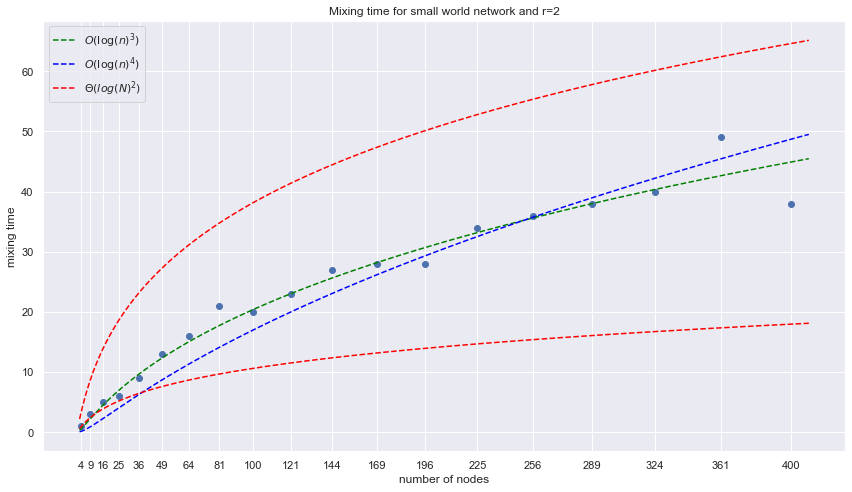

<Figure size 432x288 with 0 Axes>

In [31]:
# This code creates the plot

input_mix1=open('vector_data/mix_time_for_each_start_L=16.pkl','rb')
input_mix2=open('vector_data/mix_time_for_each_start_L=20.pkl','rb')
t1=pickle.load(input_mix1)
t2=pickle.load(input_mix2)
t1=np.array(t1)
t2=np.array(t2)



def func2(x, a):
    return a * np.log(x)**2
def func3(x, a):
    return a * np.log(x)**3
def func4(x, a):
    return a * np.log(x)**4

r=2
mixing_time=np.append(t1,t2,axis=0)
max_mixing_time=[]

#HERE WE TAKE THE MAX FOR THE POSSIBLE MIXING TIME
for i in range(0,len(mixing_time)):
    max_mixing_time.append(max(mixing_time[i]))
# filling the nodes list
nodes=[]
for L in range(2,21):
    nodes.append(L*L)

# popt is the parameter a
popt2, _ = optimize.curve_fit(func2, nodes, max_mixing_time)
popt3, _ = optimize.curve_fit(func3, nodes, max_mixing_time)
popt4, _ = optimize.curve_fit(func4, nodes, max_mixing_time)
poptexp, _ = optimize.curve_fit(exp, nodes, max_mixing_time)
#plot
fig1, ax1 = plt.subplots(figsize=(12,7))
x=np.linspace(3,410,num=10000)

ax1.scatter(nodes,max_mixing_time)
#ax1.plot(x, func2(x, *popt2),'--', color='red', label="$O(\log(n)^2)$")
ax1.plot(x, func3(x, *popt3),'--', color='green', label="$O(\log(n)^3)$")
ax1.plot(x, func4(x, *popt4),'--', color='blue', label="$O(\log(n)^4)$")
#ax1.plot(x, exp(x, *poptexp),'--', color='black', label="$n^{\Omega(1)}$")
#print('fitted function is f2(n)= ', popt2[0],'*log(n)^2')
print('fitted function is f3(n)= ', popt3[0],'*log(n)^3')
print('fitted function is f4(n)= ', popt4[0],'*log(n)^4')
#print('fitted function is exp(n)= ', poptexp[0],'*exp')
ax1.plot(x, 0.5*(np.log(x)**2),"--",color="red", label="$\Theta(log(N)^2)$")
ax1.plot(x, 1.8*(np.log(x)**2),"--",color="red")
ax1.set_title('Mixing time for small world network and r=2')
ax1.set_xlabel('number of nodes')
ax1.set_ylabel('mixing time')
ax1.set_xticks(nodes)
#ax1.set_xticks(nodes)
ax1.legend()
plt.tight_layout()
plt.savefig(currentdir+'/Plots_new/'+'Mixing_time_large_for_r={}.png'.format(r), dpi=300)
plt.show()
plt.tight_layout()



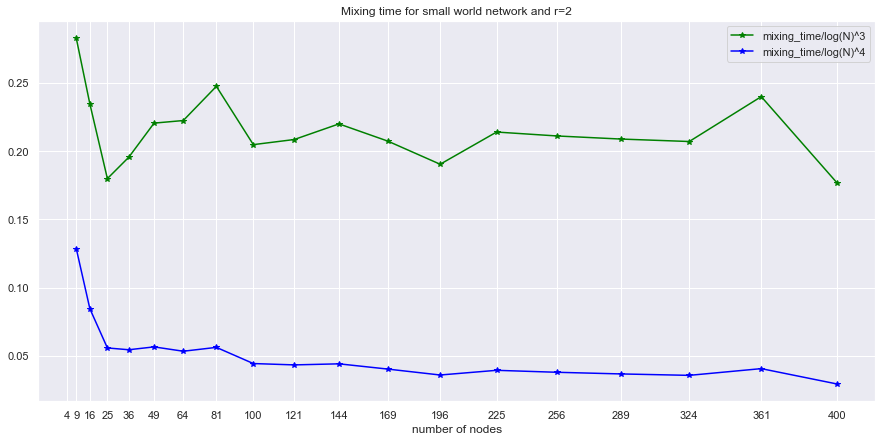

In [28]:
fig1, ax1 = plt.subplots(figsize=(15,7))
#ax1.plot(nodes[1:],max_mixing_time[1:]/(np.log(nodes[1:])**2),"*-", color="red", label="mixing_time/log(N)^2")
ax1.plot(nodes[1:],max_mixing_time[1:]/(np.log(nodes[1:])**3),"*-", color="green", label="mixing_time/log(N)^3")
ax1.plot(nodes[1:],max_mixing_time[1:]/(np.log(nodes[1:])**4),"*-", color="blue", label="mixing_time/log(N)^4")
                                                                                                                       
                                                                                                           
ax1.set_title('Mixing time for small world network and r=2')
ax1.set_xlabel('number of nodes')
ax1.set_xticks(nodes)
ax1.legend()

It is difficult to say which is the right answer between a trend of $O(\log(N)^4)$ or $\Theta(\log(N)^2)$, we should have more mixing time data related to a graph with a higher number of nodes, but this is a rather difficult task for a normal PC as the problem has an exponential increase in complexity and more over is not even self averaging.

We can say that both trend are reasonable, and also that a new trend of $O(\log(N)^3)$ should be considered. 

### Mixing time for different r parameter

We compute the mixing time for r=[0.1,1,3,100] for N up to 100 nodes.

In [6]:
# Creation of the graphs
for r in tqdm([0.1,1,3,100]):
    for L in range(3,11):
        G=small_world_2d_new(L,r,seed=42)
        output = open("Small_world_graphs/graph_L={}_r={}.pkl".format(L,r),'wb')
        pickle.dump(G,output)
        output.close()

In [10]:
# computation of the mixing time, here we don't store in our database the paths
max_steps_vec=[10,15,20,25,30,35,45,50]
max_walks_vec=[]
for L in range(3,11):
    max_walks_vec.append(50*(L**2))

mixing_time=[]
for r in tqdm([0.1,1,3,100]):
    count = 0
    mixing_time_graph_r=[]
    for L in range(3,11):
        mixing_time_graph_start=[]
        max_walks=max_walks_vec[count]
        max_steps=max_steps_vec[count]
        input_graph = open("Small_world_graphs/graph_L={}_r={}.pkl".format(L,r),'rb')
        G = pickle.load(input_graph)
        for v in G:
            paths = get_path_forG(G,L, max_steps=max_steps, max_walks=max_walks, start_node=v,
                                random_walk_function=lazy_2d_random_walk)
            norm_vector = get_L1_norm(G,L,paths,max_steps,max_walks,regular_graph=False)
            for variance in norm_vector:
                if variance<0.25: 
                    mixing_time_graph_start.append(list(norm_vector).index(variance)+1)
                    break
        mixing_time_graph_r.append(max(mixing_time_graph_start))
        count = count+1
    mixing_time.append(mixing_time_graph_r)

# Store the mixing time vector
output = open("vector_data/different_r_mixing_time.pkl",'wb')
pickle.dump(mixing_time,output)
output.close()

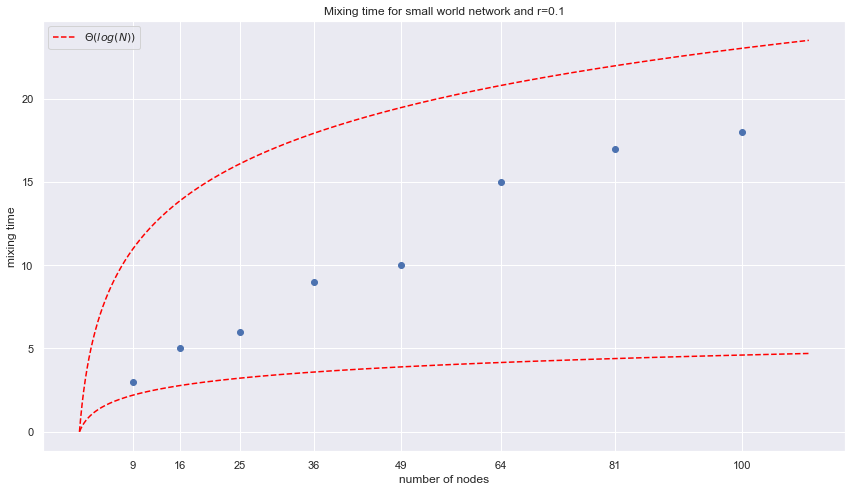

In [20]:
# This code creates the plot for r=100
def exp(x, a):
    return x**a 
def log(x,a):
    return a*np.log(x)
r=0.1
nodes=[]
for L in range(3,11):
    nodes.append(L*L)


input_mix = open("vector_data/different_r_mixing_time.pkl",'rb')
mixing_time_vec = pickle.load(input_mix)
mixing_time = mixing_time_vec[0]

popt2, _ = optimize.curve_fit(exp, nodes, mixing_time)
fig1, ax1 = plt.subplots(figsize=(12,7))
x=np.linspace(1,110,num=10000)
ax1.scatter(nodes,mixing_time)
ax1.plot(x, 1*np.log(x),"--",color="red", label="$\Theta(log(N))$")
ax1.plot(x, 5*np.log(x),"--",color="red")
#ax1.plot(x, exp(x, *popt2),'--', color='green', label="exponential $e^k$, k={:.2f}".format(popt2[0]))
ax1.set_title('Mixing time for small world network and r={}'.format(r))
ax1.set_xlabel('number of nodes')
ax1.set_ylabel('mixing time')
ax1.set_xticks(nodes)
ax1.legend()
plt.tight_layout()
plt.savefig(currentdir+'/Plots_new/'+'Mixing_time_r={}.png'.format(r), dpi=300)
plt.show()


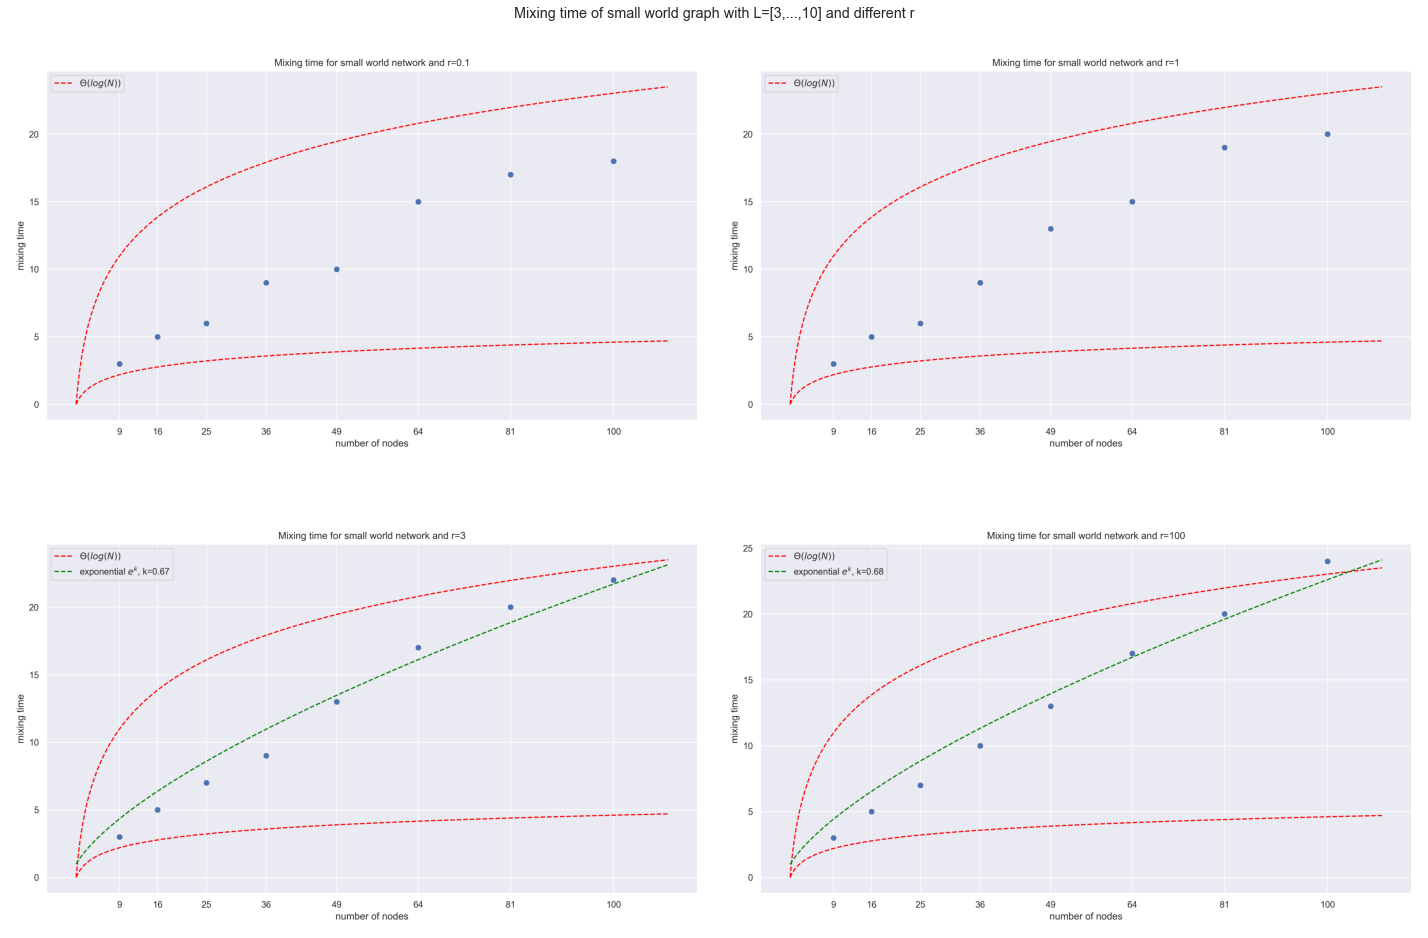

In [21]:
#COLLECTING THE DATA
files=[]
for r in [0.1,1,3,100]:
    files.append("Plots_new/Mixing_time_r={}.png".format(r))

plt.figure(figsize=(20, 14))
plt.suptitle('Mixing time of small world graph with L=[3,...,10] and different r')

for i, file_name in enumerate(files):
    plt.subplot(2, 2, i+1)
    plt.imshow(plt.imread(file_name))
    plt.axis('off')

plt.tight_layout()
plt.show()

We can see that for $r<2$ the behaviour the mixing_time is $\Theta(\log(N))$ (is bounded from above and below by a logarithmic function), but for r>2 this logarithmic increase is broken. This is a clear consequence of the fact that the bigger $r$, the less long range edge there are. 

# comparison with the mixing time of a normal torus graph

we compute now the mixing time for a normal torus graph and lazy random walks. This is a simpler task, the graph is regular, hence we can study the random walk distribution only considering a single initial starting point.

In [83]:
# computation of the mixing time for normal 2d graph, here we don't store in our database the paths

max_steps=150
max_walks_vec=10000
mixing_time=[]
for L in tqdm(range(2,21)):
    G=nx.grid_2d_graph(L,L,periodic=True)
    start=(0,0)
    paths = get_path_forG(G,L, max_steps=max_steps, max_walks=max_walks, start_node=start,
                                random_walk_function=lazy_2d_random_walk)
    norm_vector = get_L1_norm(G,L,paths,max_steps,max_walks,regular_graph=True)
    for variance in norm_vector:
        if variance<0.25: 
            mixing_time.append(list(norm_vector).index(variance)+1)
            break

# Store the mixing time vector
output = open("vector_data/torus_graph_mixing_time.pkl",'wb')
pickle.dump(mixing_time,output)
output.close()

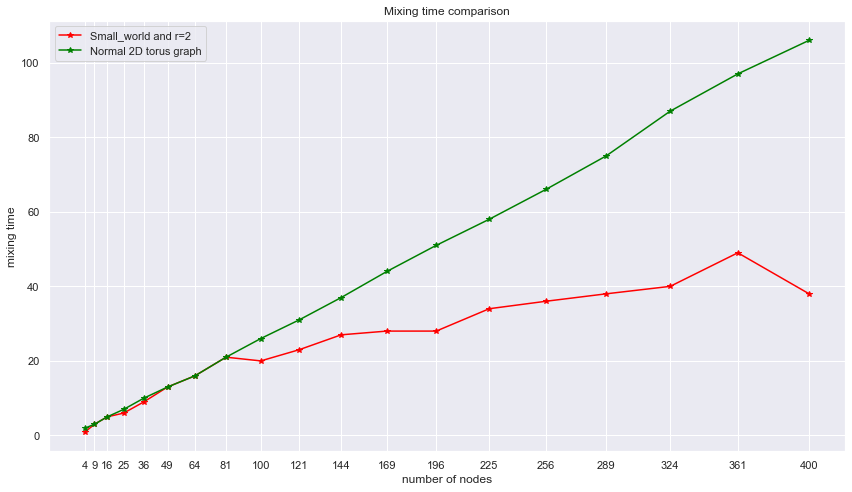

In [87]:
# Plot

input_mix1=open('vector_data/mix_time_for_each_start_L=16.pkl','rb')
input_mix2=open('vector_data/mix_time_for_each_start_L=20.pkl','rb')
t1=pickle.load(input_mix1)
t2=pickle.load(input_mix2)
t1=np.array(t1)
t2=np.array(t2)
mixing_time_small_world_vec=[]
mixing_time_small_world_vec=np.append(t1,t2,axis=0)
mixing_time_small_world=[]
for i in range(0,len(mixing_time_small_world_vec)):
    mixing_time_small_world.append(max(mixing_time_small_world_vec[i]))

input_mix = open("vector_data/torus_graph_mixing_time.pkl",'rb')
mixing_time_normal=pickle.load(input_mix)

nodes=[]
for L in range(2,21):
    nodes.append(L**2)

fig1, ax1 = plt.subplots(figsize=(12,7))
ax1.plot(nodes, mixing_time_small_world,"*-",color="red", label="Small_world and r=2")
ax1.plot(nodes, mixing_time_normal,"*-",color="green", label="Normal 2D torus graph")
ax1.set_title('Mixing time comparison'.format(r))
ax1.set_xlabel('number of nodes')
ax1.set_ylabel('mixing time')
ax1.legend()
ax1.set_xticks(nodes)
plt.savefig(currentdir+'/Plots_new/'+'Mixing_time_comparison.png'.format(r), dpi=300)
plt.tight_layout()

It is remarkable to notice that for a small graph there is no such a great difference, but after a certain value the two graphs start to behave differently, in fact for N=400 in the small world graph we have a significat reduction in the mixing time in contrast to a simple torus graph with neirest neighbour edges.

# Phase Transition

For a fixed number of nodes (we use here L=10 namely 100 nodes), if we plot the mixing time agains the r parameter we should observe a variation in the behaviour of the mixing time line at r=2

In [2]:

# computation of the mixing time, here we don't store in our database the paths
max_walks=10000
max_steps=80
for L in range(12,14):
    mixing_time_r=[]
    for r in tqdm([0.01,0.1,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,10]):
        G = small_world_2d_new(L,r,seed=42)
        mixing_time_graph_start=[]
        for v in G:
            paths = get_path_forG(G,L, max_steps=max_steps, max_walks=max_walks, start_node=v,
                                random_walk_function=lazy_2d_random_walk)
            norm_vector = get_L1_norm(G,L,paths,max_steps,max_walks,regular_graph=False)
            for variance in norm_vector:
                if variance<0.25: 
                    mixing_time_graph_start.append(list(norm_vector).index(variance)+1)
                    break
        mixing_time_r.append(max(mixing_time_graph_start))

    # Store the mixing time vector
    output = open("vector_data/different_r_same_L={}_mixing_time.pkl".format(L),'wb')
    pickle.dump(mixing_time_r,output)
    output.close()

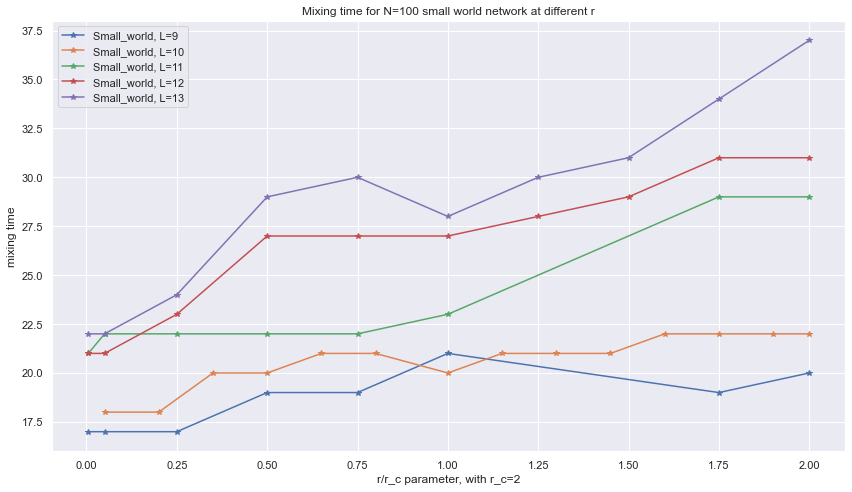

In [11]:
input_mix1=open("vector_data/different_r_same_L=9_mixing_time.pkl",'rb')
input_mix2=open("vector_data/different_r_same_L=10_mixing_time.pkl",'rb')
input_mix3=open("vector_data/different_r_same_L=11_mixing_time.pkl",'rb')
input_mix4=open("vector_data/different_r_same_L=12_mixing_time.pkl",'rb')
input_mix5=open("vector_data/different_r_same_L=13_mixing_time.pkl",'rb')
mixing_time1=pickle.load(input_mix1)
mixing_time2=pickle.load(input_mix2)
mixing_time3=pickle.load(input_mix3)
mixing_time4=pickle.load(input_mix4)
mixing_time5=pickle.load(input_mix5)
r_vec1=[0.01,0.1,0.5,1.0,1.5,2.0,3.5,4.0,10]
r_vec1=np.array(r_vec1)
r_vec1=r_vec1/2
r_vec2=[0.1,0.4,0.7,1.0,1.3,1.6,2.0,2.3,2.6,2.9,3.2,3.5,3.8,4.0]
r_vec2=np.array(r_vec2)
r_vec2=r_vec2/2
r_vec3=[0.01,0.1,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,10]
r_vec3=np.array(r_vec3)
r_vec3=r_vec3/2
fig1, ax1 = plt.subplots(figsize=(12,7))
ax1.plot(r_vec1[:-1], mixing_time1[:-1],"*-", label="Small_world, L=9")
ax1.plot(r_vec2, mixing_time2[1:-1],"*-", label="Small_world, L=10")
ax1.plot(r_vec1[:-1], mixing_time3[:-1],"*-", label="Small_world, L=11")
ax1.plot(r_vec3[:-1], mixing_time4[:-1],"*-", label="Small_world, L=12")
ax1.plot(r_vec3[:-1], mixing_time5[:-1],"*-", label="Small_world, L=13")
#ax1.plot(0, mixing_time[0],"*",color="blue", label="for r=0.001")
#ax1.plot(4.5, mixing_time[-1],"*",color="blue", label="for r=100")
ax1.set_title('Mixing time for N=100 small world network at different r')
ax1.set_xlabel('r/r_c parameter, with r_c=2')
ax1.set_ylabel('mixing time')
ax1.legend()
plt.savefig(currentdir+'/Plots_new/'+'Mixing_time_for_L=10_different_r.png', dpi=300)
plt.tight_layout()

For L<10 we don't see a clear difference in the trend, as observed before these graphs behave similarly to a simple torus graph. But for L>10 we start to see after r=2 a alight increase of the mixing time that presumably would become very sharp for a graph with a high number of nodes.

# Study of random walks on different network types

In this section we study the behaviour and statistics of the random walk on different networks. In the simple random walk we go in one time step from the current node to any of it's neighbours, i.e. adjacent nodes, with equal probability $1/\text{degree}(n_i)$. This simple random we briefly study on a 2 dimensional lattice graph, on the small world graph and on a sparse lattice (where we start with a 2d lattice and then a given fraction of the nodes is removed).

In [2]:
def node_dist_jointplot(at_step: int, using_walks: np.ndarray, 
                        L: int, marginal_max: float = 1., save_to_file=None,
                        title=None):
    # x and y coordinates of random walker
    x_data = using_walks[:, at_step, 0]
    y_data = using_walks[:, at_step, 1]
    # plot histgram of coordinates on lattice
    node_dist_plot = sns.jointplot(x=x_data, y=y_data,
                kind='kde', shade=True, xlim=(0, L), ylim=(0, L),
                marginal_ticks=True, scale=3, space=.5)
    if title is not None:
        plt.suptitle(title, y=1.0)
    # axis limits
    node_dist_plot.ax_marg_y.set_xlim((0, marginal_max))
    node_dist_plot.ax_marg_x.set_ylim((0, marginal_max))
    # plot cooridnates as points
    node_dist_plot.plot_joint(plt.scatter, alpha=0.2, s=4, color=sns.color_palette()[1])
    # save or show
    if save_to_file is not None:
        plt.savefig(currentdir+'/Plots/'+save_to_file, dpi=300)
    else:
        plt.show()

In [24]:
# graph parameters
L = 50
r = 2.0
# walk parameters
max_walks = int(2e3)
max_steps = int(5e1)
# load graph
graph_file = open(currentdir+'/Pickle_Graphs/small_world_L={}_r={:.1f}_seed=1312.pkl'.format(L, r), 'rb')
G_small_world = pickle.load(graph_file)
graph_file.close()
# random walk
walks = np.array([np.array(simple_2d_random_walk(
    G_small_world, L, max_steps, start_node=(int(L/2), int(L/2)))
    )[:, 0] for _ in range(max_walks)])

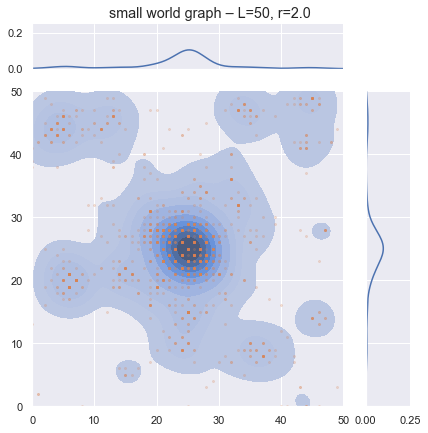

In [25]:
# plot histogram
node_dist_jointplot(at_step=8, using_walks=walks, L=L, marginal_max=0.25, title='small world graph – L=50, r=2.0')

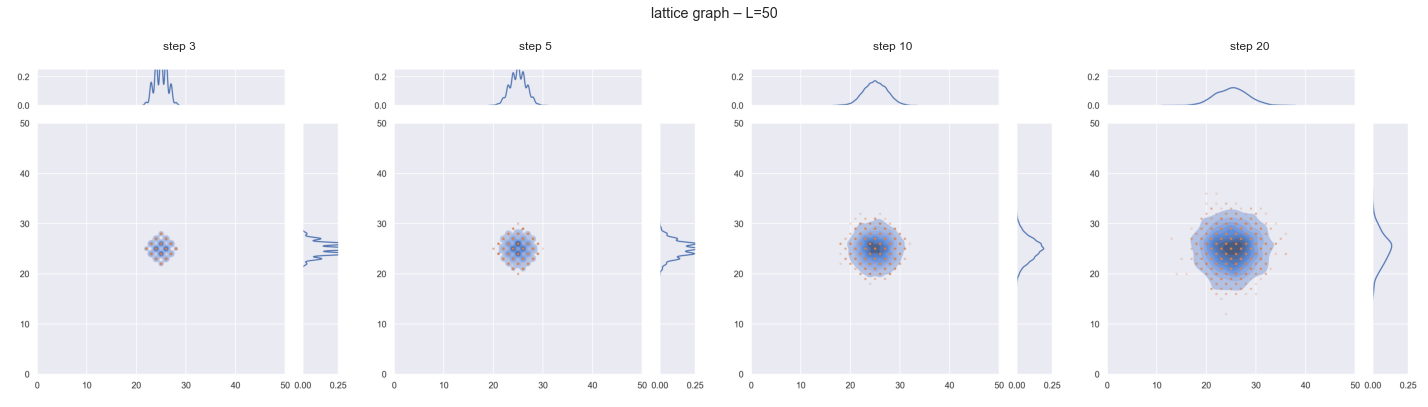

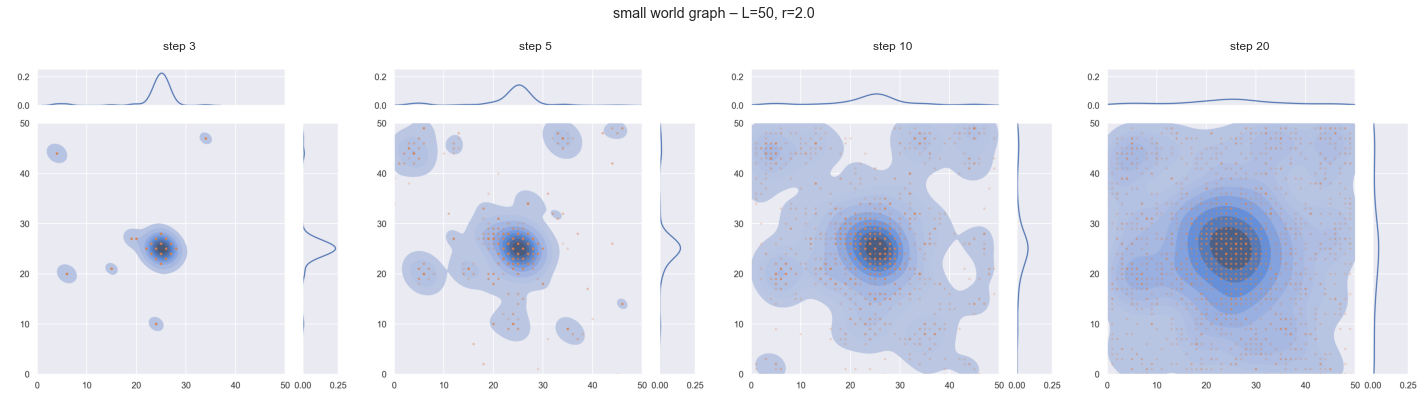

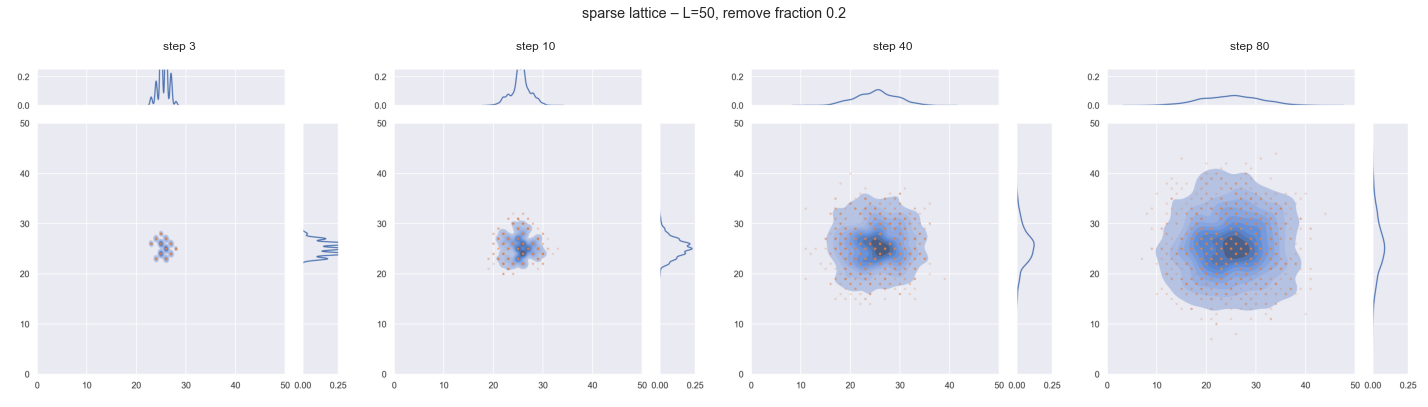

In [26]:
# lattice
plt.figure(figsize=(20, 6))
plt.suptitle('lattice graph – L=50')

for i, step in enumerate(['003', '005', '010', '020']):
    plt.subplot(1, 4, i+1)
    photo=plt.imread('Plots/lattice_L=50_node-distribution-at-step-{}.png'.format(step))
    plt.title('step {}'.format(int(step)))
    plt.axis('off')
    plt.imshow(photo)

plt.tight_layout()
plt.show()

# small world
plt.figure(figsize=(20, 6))
plt.suptitle('small world graph – L=50, r=2.0')

for i, step in enumerate(['003', '005', '010', '020']):
    plt.subplot(1, 4, i+1)
    photo=plt.imread('Plots/small_world_L=50_r=2.0_node-distribution-at-step-{}.png'.format(step))
    plt.title('step {}'.format(int(step)))
    plt.axis('off')
    plt.imshow(photo)

plt.tight_layout()
plt.show()

# sparse lattice
plt.figure(figsize=(20, 6))
plt.suptitle('sparse lattice – L=50, remove fraction 0.2')

for i, step in enumerate(['003', '010', '040', '080']):
    plt.subplot(1, 4, i+1)
    photo=plt.imread('Plots/sparse_L=50_remove-fraction=0.2_node-distribution-at-step-{}.png'.format(step))
    plt.title('step {}'.format(int(step)))
    plt.axis('off')
    plt.imshow(photo)

plt.tight_layout()
plt.show()

Here we see the distribution of the random walkers position on the different graph types after a given number of steps. Therefore we took around $300$ individual random walk trajectories starting at the same node and computed the distribution of the random walkers coordinates at each step.

- The first row shows the distribution of the position on a 2 dimensional lattice after $3$, $5$, $10$ and $20$ steps. Here we see the distribution on the individual axis seems to be similar to a Gaussian, which we would expect from theory for a simple random walk on a lattice. Also it evolves evenly in every direction.
- The second row shows the position's distribution on the small worl graph with $L^2$ nodes, $L = 50$, and $r=2.0$ again after $3$, $5$, $10$, $20$ steps. Already after three steps we see that some of the trajectories reached nodes that on the underlying lattice are "far" away from the starting node. So we clearly see the long range edges that were added during construction of the small world graph. This small world property leads to a much faster spreading of the distribution over the whole lattice than for the previously mentioned graph.
- Lastly we look at the random walk on a sparse lattice graph, where we start with a 2d lattice and then $20%$ of the nodes are removed. Here we see that compared to the simple 2d lattice graph we almost need double the amount of steps to cover the same area with the random walkers position distribution. So the mean square displacement (MSD) $\left\langle r^2 (t) \right\rangle$, which measures the squared distance of starting to end point after $t$ steps, does grow much slower with $t$ than on the lattice or small world graph.

This gives us also a feeling of how fast information spreads to a system depending on the number of edges incident to each node and also the distance between the nodes they connect. For the simple 2d lattice the distance each edge covers is $1$, since only nearest neighbours are connected. But for the small world graph we introduced on average one new edge to each node that covers longer distances, depending on the parameter $r$. For smaller $r$ the probability of a new edge to connect farther away nodes is higher and for bigger $r$ the distance between nodes connected by the new edges is (on average) smaller.

# Study of the MSD of random walks on the small world graph

In this section we study the MSD of random walks on our small world graph for different values of the parameter $r$ which is used in construction of the small world graph and strongly influences the character of the network.

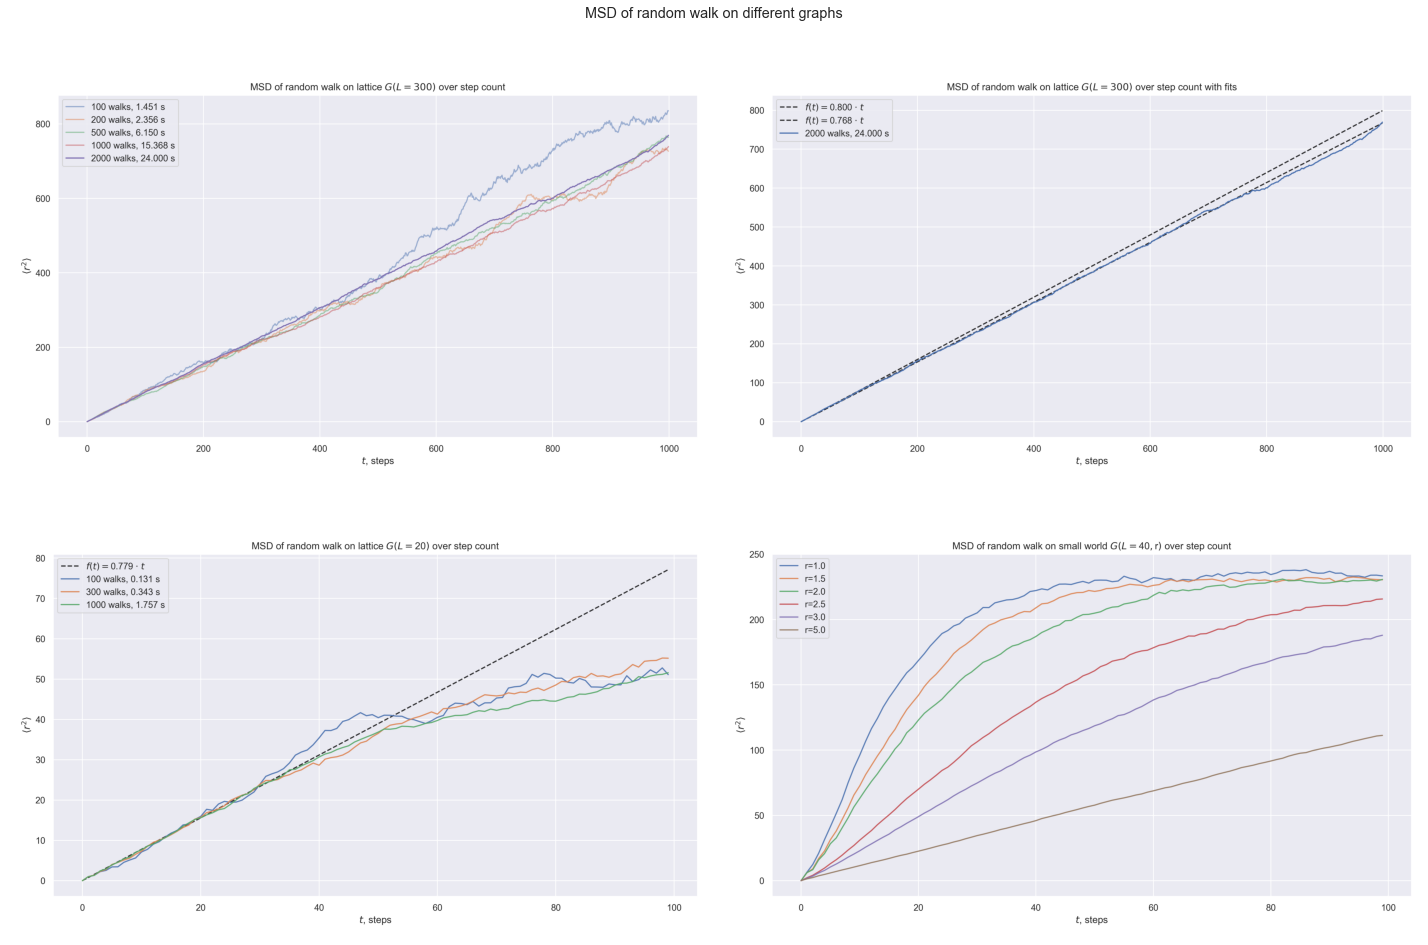

In [27]:
files = ['Plots/lattice_L=300_msd-for-different-maxwalks.png',
         'Plots/lattice_L=300_msd-fits.png',
         'Plots/lattice_L=20_msd-for-different-maxwalks.png',
         'Plots/small_world_L=40_msd-for-different-r-values.png']

plt.figure(figsize=(20, 14))
plt.suptitle('MSD of random walk on different graphs')

for i, file_name in enumerate(files):
    plt.subplot(2,2,i+1)
    plt.imshow(plt.imread(file_name))
    plt.axis('off')

plt.tight_layout()
plt.show()

The first plot (upper left) shows $\left\langle r^2\right\rangle$ for the simple random walk for $1000$ steps when using different total number of walks that we average over. From theory we expect the dependence $\left\langle r^2\right\rangle \propto t$ and as we can see, using a higher number of walks to average over, we get closer to a clearly linear functional dependence. In the second plot we further strengthen this point by plotting a linear function alongside the MSD from our data.

Since we deal with finite size lattices, we show that for a smaller sized lattice graph we get finite size effect, where after some amount of steps the MSD deviates from the expected linear behaviour like in the lower left plot where the lattice side length is $L=20$.

Now for our small world graph depending on the parameter $r$ and therefore the number of longer ranged edges, we in some cases approach this limit much faster and the finite size effects play a big role already after a small number of steps. For $r=1.0$ the random walk propagates much faster through our network than for a bigger value like $r=5.0$.

In [3]:
def end_to_end_distance(G, L, max_steps, max_walks, start_node=(0, 0), 
        use_random_starting_node=False, random_walk_function=simple_2d_random_walk, parallel=True):
    '''
    Average distance between start and end point of random walk for every step until a given max.

    Arguments:
    - G:                        graph, based on a 2d lattice
    - L:                        side length L of the 2d lattice base of G
    - max_steps:                number of steps the random walker takes in total
    - max_walks:                number of walks to simulate and average over
    - start_node:               node to start random walk from, default=(0,0)
    - use_random_starting_node: start on a randomly chosen node, default=False
    - random_walk_function:     function to use for random walk, default=simple_2d_random_walk
    - parallel:                 use parallel computation for separate walks, default=True

    Return:
    - dist_2d_mean: averaged end to end distance fo random walk for every step
    '''
    # check if using parallel computation
    if parallel:
        # seed list to have independent parallel simulations
        seed_list = np.random.permutation(np.arange(0, max_walks)).tolist()
        # list of random walks (dim = (max_walks, max_steps))
        pool = Pool(cpu_count())
        walks = np.array(pool.starmap_async(
            random_walk_function, 
            [(G, L, max_steps, start_node, use_random_starting_node, seed) for seed in seed_list]
            ).get())[:,:,1]
        pool.close()
    else:
        # list of random walks (dim = (max_walks, max_steps))
        walks = np.array([np.array(random_walk_function(
            G, L, max_steps, start_node, use_random_starting_node=use_random_starting_node)
            )[:,0] for _ in range(max_walks)])

    # calculate distances, use factor to rescale if 1d distance is larger L/2, average over multiple walks
    start_nodes_repeat = np.repeat(walks[:, 0], walks.shape[1], axis=0).reshape(walks.shape)
    factor = np.floor(2.*abs(walks-start_nodes_repeat)/L)
    dist_1d = abs(factor*L - abs(walks-start_nodes_repeat))
    dist_2d_mean = np.sqrt( dist_1d[:,:,0]**2. + dist_1d[:,:,1]**2. ).mean(axis=0)

    return dist_2d_mean

In [20]:
# random walk parameters
max_steps = int(5e1)
max_walks = int(1e4)

# graph parameters
seed = 1312
L_list = [80, 100, 120, 140, 160]
r_list = [2.0]

# MSD lists
r_sq_all_lazy = []
r_sq_all_simple = []

for r_i in r_list:
    r_sq_lazy = []
    r_sq_simple = []
    for L_i in tqdm(L_list):
        # load graph
        graph_file = open(currentdir+'/Pickle_Graphs/'+'small_world_L={}_r={:.1f}_seed={}.pkl'.format(L_i, r_i, seed), 'rb')
        G_i = pickle.load(graph_file)
        graph_file.close()
        # lazy random walk
        r_over_steps = end_to_end_distance(
            G=G_i, L=L_i, max_steps=max_steps, max_walks=max_walks,
            use_random_starting_node=True, random_walk_function=lazy_2d_random_walk,
            parallel=True)
        r_sq_lazy.append(r_over_steps**2.)
        # simple random walk
        r_over_steps = end_to_end_distance(
            G=G_i, L=L_i, max_steps=max_steps, max_walks=max_walks,
            use_random_starting_node=True, random_walk_function=simple_2d_random_walk,
            parallel=True)
        r_sq_simple.append(r_over_steps**2.)
    r_sq_all_lazy.append(r_sq_lazy)
    r_sq_all_simple.append(r_sq_simple)

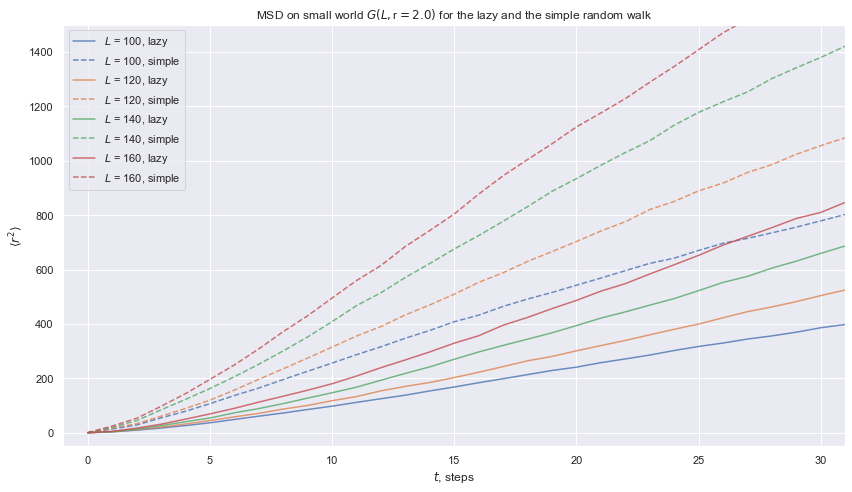

In [23]:
for idx_r in range(len(r_list)):
    r_i = r_list[idx_r]
    r_sq_lazy = r_sq_all_lazy[idx_r]
    r_sq_simple = r_sq_all_simple[idx_r]

    # plot
    fig, ax = plt.subplots(figsize=(12,7))
    ax.set_title(r'MSD on small world $G(L, $r$={})$ for the lazy and the simple random walk'.format(r_i))

    for i, L_i in enumerate(L_list[1:]):
        ax.plot(np.arange(r_sq_lazy[0].shape[0]), r_sq_lazy[i+1],
                alpha=0.8, c=sns.color_palette()[i],
                label=r'$L$ = {}, lazy'.format(L_i))
        ax.plot(np.arange(r_sq_simple[0].shape[0]), r_sq_simple[i+1],
                alpha=.8, c=sns.color_palette()[i], ls='dashed',
                label=r'$L$ = {}, simple'.format(L_i))

    ax.set_ylabel(r'$\langle r^2 \rangle$')
    ax.set_xlabel(r'$t$, steps')
    #ax.loglog()
    ax.set_ylim(-50, 1500)
    ax.set_xlim(-1, 31)
    ax.legend()
    plt.tight_layout()
    plt.show()

We can compare the $\left\langle r^2 \right\rangle$ for different network sizes and different types of random walk, the simple and the lazy random walk (as explained in the 'Creation of the small world network' notebook). The larger the network (bigger $L$ of underlying lattice), the faster the MSD grows. Also the MSD of the simple random walk is around $2.5$ times the MSD of the lazy random walk.

## Power law of MSD of random walk on small world graph

What we tried to find is the dependence of $\left\langle r^2\right\rangle$ on the number of steps $t$ and number of nodes $L^2$. We assumed to find a power law in $t$, like $$\left\langle r^2 \right\rangle \propto t^\alpha, $$ as in the 2d lattice case, where $\alpha=1$. Then we could plot $\left\langle r^2 \right\rangle / t^\alpha$ over $t$ and should find this to be constant for the right $\alpha$.

In [68]:
# random walk parameters
max_steps = int(5e1)
max_walks = int(3e4)

# graph parameters
seed = 1312
L_list = [80, 100, 120, 140, 160]
r_list = [1.0, 2.0, 3.0]

# MSD lists
r_sq_dict = {}

for r_i in r_list:
    r_sq = {}
    for L_i in tqdm(L_list):
        # load graph
        graph_file = open(currentdir+'/Pickle_Graphs/'+'small_world_L={}_r={:.1f}_seed={}.pkl'.format(L_i, r_i, seed), 'rb')
        G_i = pickle.load(graph_file)
        graph_file.close()
        # simple random walk
        r_over_steps = end_to_end_distance(
            G=G_i, L=L_i, max_steps=max_steps, max_walks=max_walks,
            use_random_starting_node=True, random_walk_function=simple_2d_random_walk,
            parallel=True)
        r_sq[L_i] = r_over_steps**2.
    r_sq_dict[r_i] = r_sq

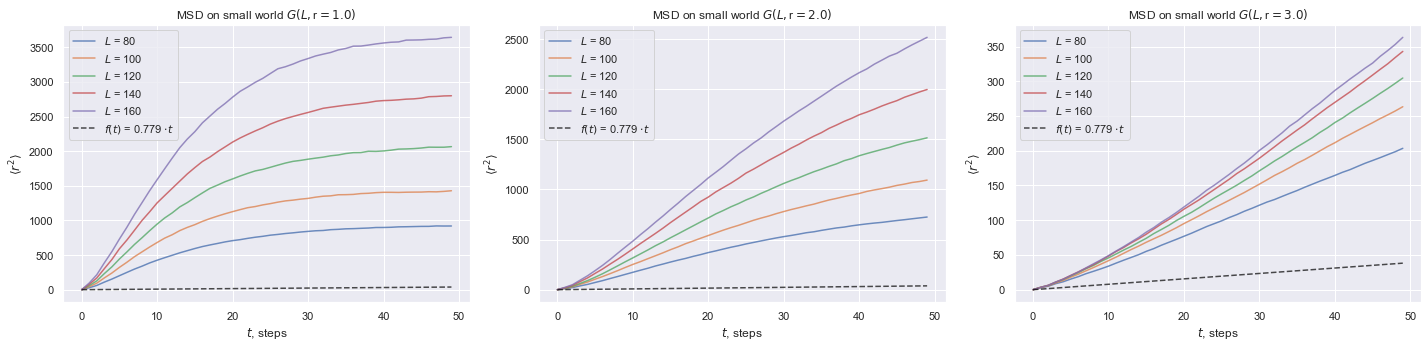

In [87]:
# plot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

r_list = [1.0, 2.0, 3.0]
L_list = [80, 100, 120, 140, 160]
alphas = [1.22, 1.22, 1.22]
for i, r_i in enumerate(r_list):
    r_sq = r_sq_dict[r_i]

    ax = axes[i]
    ax.set_title(r'MSD on small world $G(L, $r$={})$'.format(r_i))

    for L_i in L_list:
        ax.plot(np.arange(r_sq[L_i].shape[0]), r_sq[L_i] ,
                alpha=0.8,
                label=r'$L$ = {}'.format(L_i))
    ax.plot(np.arange(r_sq[L_i].shape[0]), 0.779 * np.arange(r_sq[L_i].shape[0]),
            c='black', ls='dashed', alpha=0.7, label=r'$f(t)$ = 0.779 $\cdot t$')

    ax.set_ylabel(r'$\langle r^2 \rangle$')
    ax.set_xlabel(r'$t$, steps')
    #ax.loglog()
    #ax.set_xlim(-1, 31)
    ax.legend()

plt.tight_layout()
plt.show()

As we can see here, the MSD strongly depends on the network size $L^2$ as well as the parameter $r$ which is used when creating the small world graph from a lattice. Below we try to find a suitable parameter $\alpha$ for the scaling of the MSD, but as one can see, this $\alpha$ appears to depend on the system size and also it's hard to determine correctyl since the finite size of the system becomes very relevant already after only a few steps and therefore hinders us to clearly infer the assumed power law.

For small $t<10$ we can find parameters $\alpha$ such that $\left\langle r^2 \right\rangle / t^\alpha$ is found to be almost constant, but for $t>10$ the functional dependence changes due to finite size of the system. Also at $t=1, 2$ the random walk behaves different than expected, for which we don't have an explanation.

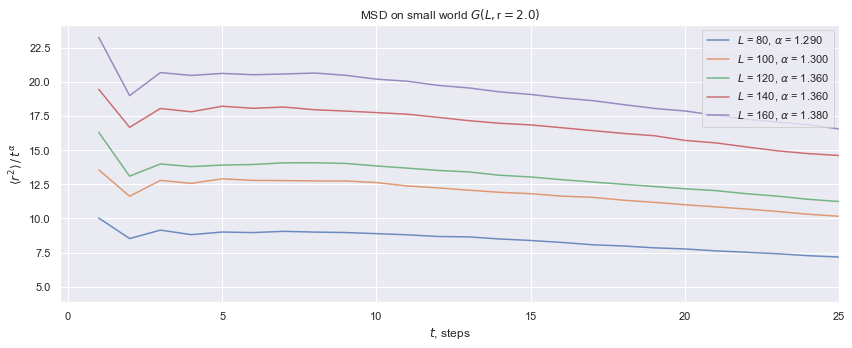

In [127]:
# plot
fig, ax = plt.subplots(figsize=(12, 5))

r_list = [2.0]
L_list = [80, 100, 120, 140, 160]
alphas = [1.29, 1.30, 1.36, 1.36, 1.38]

for i, r_i in enumerate(r_list):
    r_sq = r_sq_dict[r_i]

    ax.set_title(r'MSD on small world $G(L, $r$={})$'.format(r_i))

    for j, L_i in enumerate(L_list):
        ax.plot(np.arange(r_sq[L_i].shape[0]), r_sq[L_i] / (L_i ** 0. * np.arange(r_sq[L_i].shape[0]) ** alphas[j] ),
                alpha=0.8,
                label=r'$L$ = {}, $\alpha$ = {:.3f}'.format(L_i, alphas[j]))
    
    ax.set_ylabel(r'$\langle r^2 \rangle \, /\, t^\alpha$')
    ax.set_xlabel(r'$t$, steps')
    ax.set_xlim(-0.25, 25)
    ax.legend()

plt.tight_layout()
plt.show()